In [1]:
# путь до папки scripts с необходимыми скриптами,
# в папке preprocessing необходимые блоки, которые 
# используются для построения pipeline
# также необходим parse, в котором описано получение данных для обучения

import sys
PATH_TO_SCRIPTS = "."
sys.path.append(PATH_TO_SCRIPTS)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE

import preprocessing as prep
import parsing as pars

In [3]:
# simple_parser и nested_parser - объекты, которые описаны
# в скрипте parsing в виде класса, они должны в каком-то методе
# реализовывать логику взятия данных из хранилища
# при желании, можно написать свой парсер, по подобию описанных parser-ов
# (если вдруг появятся данные, которые лежат не в nested и не в simple форматах)

# list в котором лежат отдельные longDataFrame с данными из разных хранилищ
datasets_list = [] 

paths_to_nested = ["/home/drozdovmk/Projects/ZB/data/data_markup/cesis_nabor_0",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/demostend_0",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/samara_wind",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/Kashira_13may",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/Kashira_18jule"]
nested_parser = pars.NestedParser()
for path in paths_to_nested:
    datasets_list.append(nested_parser.get_long_df(path))
    
paths_to_simple = ["/home/drozdovmk/Projects/ZB/data/data_markup/hdf5_adaptive"]
simple_parser = pars.SimpleParser()
for path in paths_to_simple:
    datasets_list.append(simple_parser.get_long_df(path))

In [4]:
# joiner - объект класса LongJoiner из скрипта parsing (см. комментарии в parsing)

labels_to_delete = ["hit_series", "unknown"]
dict_to_rename = {"hit_g": "hit", "hit_z": "hit"}
downsampling = False
joiner = pars.LongJoiner(labels_to_delete, dict_to_rename, downsampling)

dataset = joiner.concat_datasets(datasets_list)

In [5]:
data_hdf5 = dataset[0]
labels = dataset[1]
print("Статистика по классам:")
print(labels.value_counts())

Статистика по классам:
wind       1091
hit         588
saw         267
perelaz     260
Name: count, dtype: int64


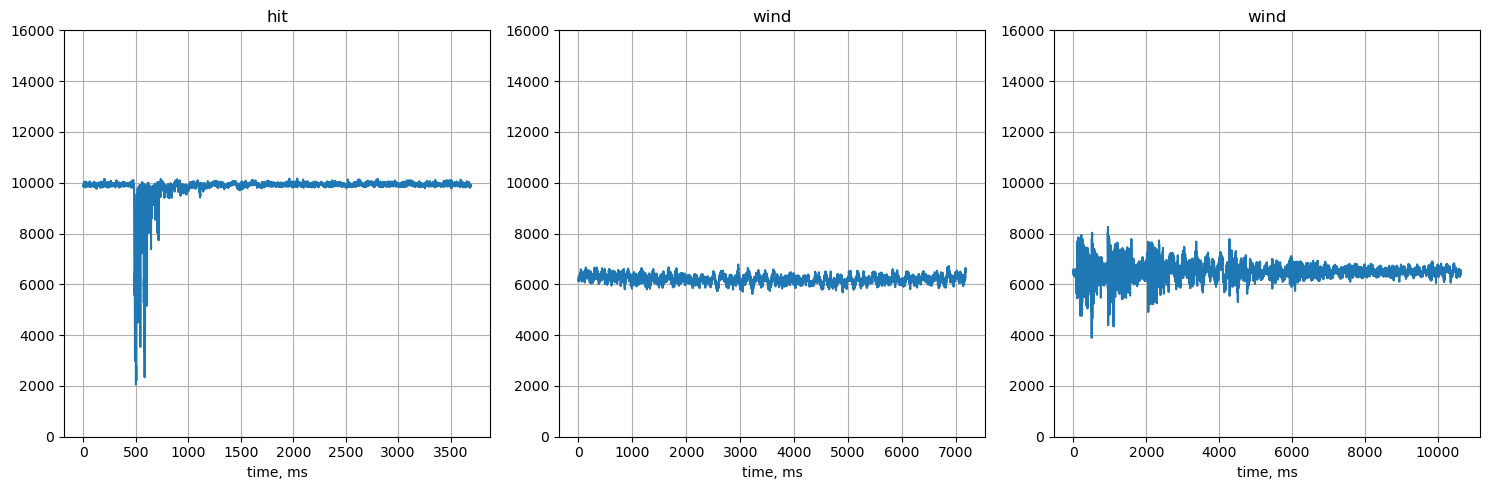

In [8]:
# Визуализация нескольких объектов
number_of_samples = 3
random_indexes = np.random.choice(data_hdf5["id"].unique(), size=number_of_samples)
fig, ax = plt.subplots(1, number_of_samples, figsize=(5*number_of_samples,5))

for i, ind in enumerate(random_indexes):
    
    ax[i].plot(data_hdf5[data_hdf5["id"] == ind].time,
               data_hdf5[data_hdf5["id"] == ind].signal_raw)
    ax[i].set_ylim([0, 16000])
    ax[i].set_title(labels[ind])
    ax[i].set_xlabel("time, ms")
    ax[i].grid()
plt.tight_layout()

In [34]:

timeTransformer = prep.TimePreprocessing(std_window = 32,
                                         mean_window = 128,
                                         normilize=True)
freqTransformer = prep.FreqPreprocessing(n_bins = 100,
                                         fs = 1000)

data_time = timeTransformer.transform(data_hdf5)
data_freq = freqTransformer.transform(data_hdf5)

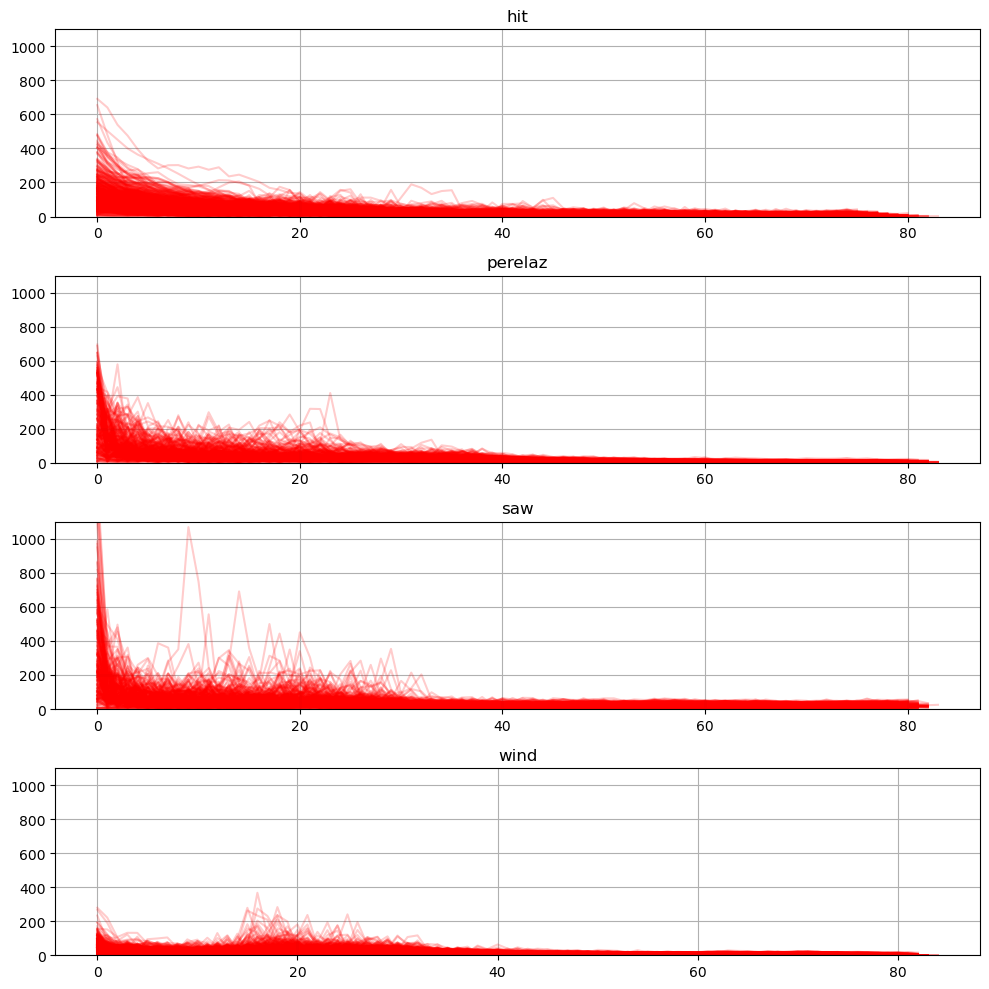

In [35]:
# визуализация спектров по классам
classnames = np.unique(labels)
id_to_label = dict(enumerate(classnames))
label_to_id = {i: j for j, i in id_to_label.items()}
fig, ax = plt.subplots(len(classnames), 1, figsize = (10,10))
for key, value in label_to_id.items():
    ax[value].set_title(key)
    ax[value].set_ylim([0, 1100])
    ax[value].grid()
    
idxs = data_freq["id"].unique()
for i in idxs:
    idx_classname = label_to_id[labels[i]]
    ax[idx_classname].plot(data_freq[data_freq["id"] == i]["signal_binned_fft"].values, alpha=0.2, c="r")
    # ax[idx_classname].plot(data_time[data_time["id"] == i]["signal_std"].values, alpha=0.02, c="r")
plt.tight_layout()

In [36]:
time_feature_extractor = Pipeline([
    ("TimePreprocessing", prep.TimePreprocessing(std_window = 32,
                                                 mean_window = 128,
                                                 normilize=True)),
    ("CustomFeatureAugmenter", prep.CustomFeatureAugmenter(column_id='id',
                                                      column_sort='time',
                                                      kind_to_fc_parameters = prep.MyCustomFeatures.time_features,
                                                      disable_progressbar=True,
                                                      n_jobs=10)),
    ])

freq_feature_extractor = Pipeline([
    ("FreqPreprocessing", prep.FreqPreprocessing(n_bins=70,
                                                 fs = 1000)),
    ("CustomFeatureAugmenter", prep.CustomFeatureAugmenter(column_id='id',
                                                           column_sort='freq_num',
                                                           default_fc_parameters = prep.MyCustomFeatures.freq_features,
                                                           disable_progressbar=True,
                                                           n_jobs = 10))
    ])

feature_union = Pipeline([
    ("FeatureUnion", FeatureUnion(transformer_list=[("timeExtractor", time_feature_extractor),
                                                    ("freqExtractor", freq_feature_extractor)])),
    ("ColumnSorter", prep.ColumnSorter())
    ])
feature_union.set_output(transform="pandas")


Pipeline(steps=[('FeatureUnion',
                 FeatureUnion(transformer_list=[('timeExtractor',
                                                 Pipeline(steps=[('TimePreprocessing',
                                                                  TimePreprocessing(mean_window=128,
                                                                                    normilize=True,
                                                                                    std_window=32)),
                                                                 ('CustomFeatureAugmenter',
                                                                  CustomFeatureAugmenter(column_id='id',
                                                                                         column_sort='time',
                                                                                         disable_progressbar=True,
                                                                                         kind_to_fc_parameters={'signal_mean': {'absolute_sum_of_chang...
                                                                                                                                      'ql': 0.0}],
                                                                                                                'energy_ratio_by_chunks': [{'num_segments': 10,
                                                                                                                                            'segment_focus': 8},
                                                                                                                                           {'num_segments': 10,
                                                                                                                                            'segment_focus': 9}],
                                                                                                                'index_mass_quantile': [{'q': 0.1}],
                                                                                                                'mean_change': None,
                                                                                                                'quantile': [{'q': 0.2},
                                                                                                                             {'q': 0.3}],
                                                                                                                'sum_values': None,
                                                                                                                'time_reversal_asymmetry_statistic': [{'lag': 2},
                                                                                                                                                      {'lag': 3}],
                                                                                                                'variance': None},
                                                                                         disable_progressbar=True))]))])),
                ('ColumnSorter', ColumnSorter())])

In [37]:
features = feature_union.transform(data_hdf5)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

In [39]:
# baseline with default params
model =RandomForestClassifier()  
model.fit(X_train, y_train)

test_pred_proba = model.predict_proba(X_test)
test_preds = model.predict(X_test)

print(classification_report(y_test, test_preds))


              precision    recall  f1-score   support

         hit       0.93      0.94      0.93       134
     perelaz       0.95      0.84      0.89        74
         saw       0.98      0.98      0.98        62
        wind       0.95      0.97      0.96       282

    accuracy                           0.95       552
   macro avg       0.95      0.93      0.94       552
weighted avg       0.95      0.95      0.95       552



In [1]:
# улучшение baseline

# import optuna
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 200),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 8),
#         "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
#         "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
#         "class_weight": trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
#         "random_state": 42
#     }
#     clf = RandomForestClassifier(**params)
#     # Оценка с помощью кросс-валидации
#     cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#     score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=cv, scoring="f1_micro").mean()
#     return score
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)

# print("Лучшие параметры:", study.best_params)
# print("Лучшая точность:", study.best_value)

In [42]:
wrong_idxs = y_test[(test_preds != y_test)].index


In [43]:
# best_params = study.best_params # when use optuna

best_params = {'n_estimators': 100,
               'max_depth': 10,
               'min_samples_split': 5,
               'min_samples_leaf': 3,
               'max_features': 'log2',
               'bootstrap': True,
               "class_weight": "balanced_subsample"}
# best_params = model.get_params()

In [44]:
clf_best = RandomForestClassifier(**best_params)


clf_best.fit(X_train, y_train)
# clf_best.fit(X_train, y_train)
train_pred = clf_best.predict(X_train)
print(classification_report(y_train, train_pred))


              precision    recall  f1-score   support

         hit       0.99      0.99      0.99       454
     perelaz       0.98      0.97      0.98       186
         saw       0.98      1.00      0.99       205
        wind       0.99      0.99      0.99       809

    accuracy                           0.99      1654
   macro avg       0.98      0.99      0.99      1654
weighted avg       0.99      0.99      0.99      1654



In [45]:
test_pred = clf_best.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         hit       0.94      0.96      0.95       134
     perelaz       0.94      0.84      0.89        74
         saw       0.97      0.98      0.98        62
        wind       0.95      0.97      0.96       282

    accuracy                           0.95       552
   macro avg       0.95      0.94      0.94       552
weighted avg       0.95      0.95      0.95       552



In [46]:

# обучаем м сохраняем итоговую модель

final_pipeline = Pipeline([("feature_extractor", feature_union),
                           ("classifier", clf_best)])
final_pipeline.set_output(transform="pandas")

Pipeline(steps=[('feature_extractor',
                 Pipeline(steps=[('FeatureUnion',
                                  FeatureUnion(transformer_list=[('timeExtractor',
                                                                  Pipeline(steps=[('TimePreprocessing',
                                                                                   TimePreprocessing(mean_window=128,
                                                                                                     normilize=True,
                                                                                                     std_window=32)),
                                                                                  ('CustomFeatureAugmenter',
                                                                                   CustomFeatureAugmenter(column_id='id',
                                                                                                          column_sort='time',
                                                                                                          disable_progressbar=True,
                                                                                                          kind_to_fc_parameters={...
                                                                                                                                 'mean_change': None,
                                                                                                                                 'quantile': [{'q': 0.2},
                                                                                                                                              {'q': 0.3}],
                                                                                                                                 'sum_values': None,
                                                                                                                                 'time_reversal_asymmetry_statistic': [{'lag': 2},
                                                                                                                                                                       {'lag': 3}],
                                                                                                                                 'variance': None},
                                                                                                          disable_progressbar=True))]))])),
                                 ('ColumnSorter', ColumnSorter())])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, max_features='log2',
                                        min_samples_leaf=3,
                                        min_samples_split=5))])

In [47]:
final_pipeline.fit(data_hdf5, labels)

Pipeline(steps=[('feature_extractor',
                 Pipeline(steps=[('FeatureUnion',
                                  FeatureUnion(transformer_list=[('timeExtractor',
                                                                  Pipeline(steps=[('TimePreprocessing',
                                                                                   TimePreprocessing(mean_window=128,
                                                                                                     normilize=True,
                                                                                                     std_window=32)),
                                                                                  ('CustomFeatureAugmenter',
                                                                                   CustomFeatureAugmenter(column_id='id',
                                                                                                          column_sort='time',
                                                                                                          disable_progressbar=True,
                                                                                                          kind_to_fc_parameters={...
                                                                                                                                 'mean_change': None,
                                                                                                                                 'quantile': [{'q': 0.2},
                                                                                                                                              {'q': 0.3}],
                                                                                                                                 'sum_values': None,
                                                                                                                                 'time_reversal_asymmetry_statistic': [{'lag': 2},
                                                                                                                                                                       {'lag': 3}],
                                                                                                                                 'variance': None},
                                                                                                          disable_progressbar=True))]))])),
                                 ('ColumnSorter', ColumnSorter())])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, max_features='log2',
                                        min_samples_leaf=3,
                                        min_samples_split=5))])

In [48]:
import joblib

joblib.dump(final_pipeline, "pipeline_with_kashira.pkl")

['pipeline_with_kashira.pkl']

In [1]:
import json
with open("classifier_config.json", "r", encoding="utf-8") as file:
    config = json.load(file)

In [3]:
config["zone"] = 4

In [4]:
config

{'model_path': 'pipeline_with_kashira.pkl',
 'indent_time': 500,
 'cooling_time': 2000,
 'max_time': 10000,
 'threshold': 3,
 'plotting': False,
 'verbose': True,
 'saving': False,
 'save_path': './alarms',
 'zone_num': '<zone_num>',
 'max_files_count': 250,
 'zone': 4}